In [1]:
# Import TensorFlow.
import tensorflow as tf

# Import TensorFlow eager execution support (subject to future changes).
import tensorflow.contrib.eager as tfe

# Enable eager execution.
tfe.enable_eager_execution()

In [2]:
# The constants we'll try to fit our variables to:
true_w = 3
true_b = 2

NUM_EXAMPLES = 1000

# Our inputs:
inputs = tf.random_normal(shape=[NUM_EXAMPLES, 1])

# Our labels, with noise:
noise = tf.random_normal(shape=[NUM_EXAMPLES, 1])
labels = inputs * true_w + true_b + noise

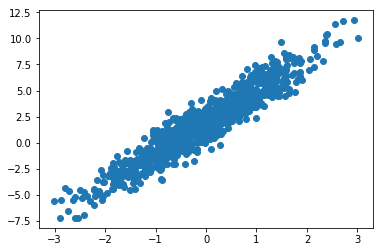

In [4]:
# Plot the Data (Optional)

import matplotlib.pyplot as plt
%matplotlib inline

plt.scatter(inputs.numpy(), labels.numpy())
plt.show()

In [5]:
# Create TensorFlow Variables using Keras's Dense layer.

wb = tf.layers.Dense(units=1, use_bias=True)

# We can access the underlying TensorFlow variables using wb.variables.
# However, the variables won't exist until the dimensions of the input
# tensors are known. Once the dimensions of the input tensors are known,
# Keras can create and initialize the variables. Until then, Keras will
# report the variables as an empty list: [].

wb.variables

[]

In [6]:
def loss_fn(inputs, labels, wb):
  """Calculates the mean L2 loss for our linear model."""
  predictions = wb(inputs)
  return tf.reduce_mean(tf.square(predictions - labels))

In [7]:
# Test loss function (optional).

loss_fn(inputs, labels, wb)

<tf.Tensor: id=49, shape=(), dtype=float32, numpy=24.200489>

In [8]:
# At this point, the variables exist, and can now be queried:

w, b = wb.variables
print("w: " + str(w.read_value()))
print("b: " + str(b.read_value()))

w: tf.Tensor([[-1.4767215]], shape=(1, 1), dtype=float32)
b: tf.Tensor([0.], shape=(1,), dtype=float32)


In [9]:
# Produce our gradients function. See description above for details about
# the returned function's signature.

value_and_gradients_fn = tfe.implicit_value_and_gradients(loss_fn)

In [10]:
# Show outputs of value_and_gradients_fn.

print("Outputs of value_and_gradients_fn:")

value, grads_and_vars = value_and_gradients_fn(inputs, labels, wb)

print('Loss: {}'.format(value))
for (grad, var) in grads_and_vars:
  print("")
  print('Gradient: {}\nVariable: {}'.format(grad, var))

Outputs of value_and_gradients_fn:
Loss: 24.200489044189453

Gradient: [[-8.787546]]
Variable: <tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[-1.4767215]], dtype=float32)>

Gradient: [-3.643493]
Variable: <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([0.], dtype=float32)>


In [11]:
optimizer = tf.train.GradientDescentOptimizer(learning_rate=0.1)

In [12]:
# Test the optimizer.

print("Values of w, b, BEFORE applying gradients:")
w, b = wb.variables
print(w.read_value().numpy(), b.read_value().numpy())
print()

# Calculate the gradients:
empirical_loss, gradients_and_variables = value_and_gradients_fn(
    inputs, labels, wb)
optimizer.apply_gradients(gradients_and_variables)

print("Values of w, b, AFTER applying gradients:")
print(w.read_value().numpy(), b.read_value().numpy())

Values of w, b, BEFORE applying gradients:
[[-1.4767215]] [0.]

Values of w, b, AFTER applying gradients:
[[-0.5979669]] [0.3643493]


[0.1072838306427002, 0.6733308434486389, 1.1276848316192627, 1.4924124479293823, 1.7852153778076172, 2.020294666290283, 2.2090437412261963, 2.3606045246124268, 2.4823126792907715, 2.5800554752349854]


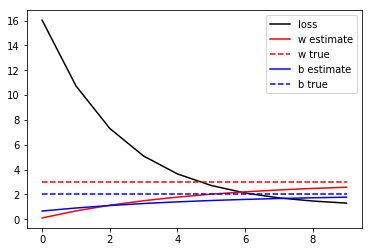

In [13]:
# Train our variables.

# numpy is used for its asscalar() function.
import numpy as np

num_training_steps = 10

def train_model(inputs, labels, wb, optimizer, num_training_steps):
  loss_at_step = []
  w_at_step = []
  b_at_step = []
  for step_num in range(num_training_steps):
    loss, gradients_and_variables = value_and_gradients_fn(inputs, labels, wb)
    loss_at_step.append(np.asscalar(loss.numpy()))
    
    optimizer.apply_gradients(gradients_and_variables)
    w, b = wb.variables
    w_at_step.append(np.asscalar(w.read_value().numpy()))
    b_at_step.append(np.asscalar(b.read_value().numpy()))

  print(w_at_step)
  t = range(0, num_training_steps)
  plt.plot(t, loss_at_step, 'k',
           t, w_at_step, 'r',
           t, [true_w] * num_training_steps, 'r--',
           t, b_at_step, 'b',
           t, [true_b] * num_training_steps, 'b--')
  plt.legend(['loss', 'w estimate', 'w true', 'b estimate', 'b true'])
  plt.show()

train_model(inputs, labels, wb, optimizer, num_training_steps)

In [14]:
# tfe.implicit_gradients() demo
gradients_fn = tfe.implicit_gradients(loss_fn)

# Returns only gradients and variables:
gradients_fn(inputs, labels, wb)

[(<tf.Tensor: id=541, shape=(1, 1), dtype=float32, numpy=array([[-0.7850183]], dtype=float32)>,
  <tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.5800555]], dtype=float32)>),
 (<tf.Tensor: id=539, shape=(1,), dtype=float32, numpy=array([-0.3927026], dtype=float32)>,
  <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([1.7785621], dtype=float32)>)]

In [15]:
# tfe.implicit_value_and_gradients() demo
value_gradients_fn = tfe.implicit_value_and_gradients(loss_fn)

# Returns the value returned by the function passed in, gradients, and variables:
value_gradients_fn(inputs, labels, wb)

(<tf.Tensor: id=557, shape=(), dtype=float32, numpy=1.1942993>,
 [(<tf.Tensor: id=579, shape=(1, 1), dtype=float32, numpy=array([[-0.7850183]], dtype=float32)>,
   <tf.Variable 'dense/kernel:0' shape=(1, 1) dtype=float32, numpy=array([[2.5800555]], dtype=float32)>),
  (<tf.Tensor: id=577, shape=(1,), dtype=float32, numpy=array([-0.3927026], dtype=float32)>,
   <tf.Variable 'dense/bias:0' shape=(1,) dtype=float32, numpy=array([1.7785621], dtype=float32)>)])